In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import nltk

# Download necessary NLTK data
nltk.download('wordnet')  # Required for WordNetLemmatizer
nltk.download('omw-1.4')  # Required for wordnet support for Lemmatizer
nltk.download('stopwords')  # Required for stopword removal
nltk.download('punkt')  # Required for tokenization

import nltk
import os
import zipfile

# Define the NLTK data path
nltk_data_path = "/kaggle/working/nltk_data"
os.makedirs(nltk_data_path, exist_ok=True)

# Add the path to NLTK's search paths
nltk.data.path.append(nltk_data_path)

# Download required resources
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)

# Extract .zip files in /corpora
for zip_file in ['wordnet.zip', 'omw-1.4.zip']:
    with zipfile.ZipFile(f"{nltk_data_path}/corpora/{zip_file}", 'r') as zip_ref:
        zip_ref.extractall(f"{nltk_data_path}/corpora")

# Verify extracted content
print("Extracted corpora:", os.listdir(f"{nltk_data_path}/corpora"))

# Test wordnet
from nltk.corpus import wordnet
print(wordnet.synsets('test'))  # Should print a list of synsets

# Test stopwords
from nltk.corpus import stopwords
print(stopwords.words('english')[:10])  # Should print the first 10 English stopwords

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /kaggle/working/nltk_data...
[nltk_data]   Package punkt is 

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="ipywidgets")


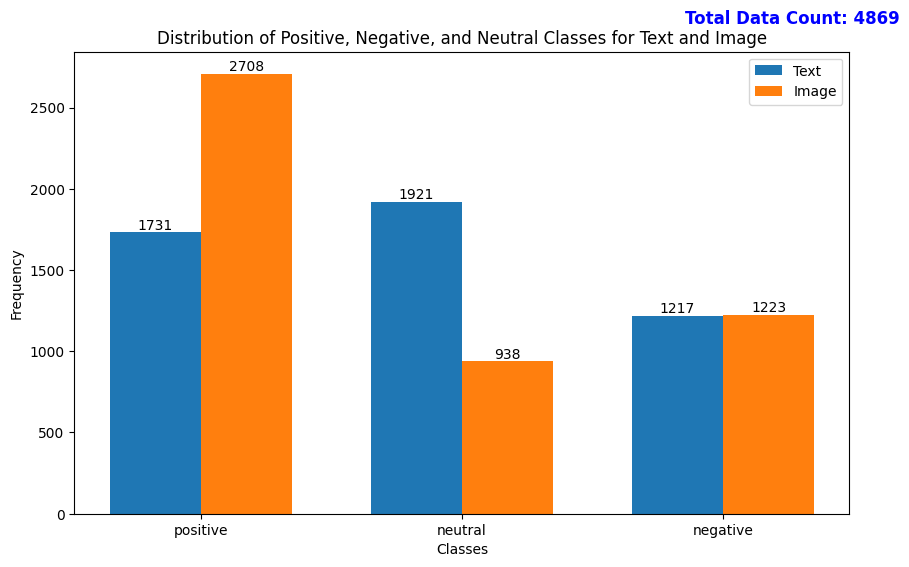

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Path to the label file
label_file_path = '/kaggle/input/mvsasingle/MVSA_Single/labelResultAll.txt'

# Load the label data into a DataFrame
labels_df = pd.read_csv(label_file_path, sep='\t')

# Split the text and image labels into separate columns
labels_df[['text_label', 'image_label']] = labels_df['text,image'].str.split(',', expand=True)

# Count the distribution of classes for both text and image labels
text_distribution = labels_df['text_label'].value_counts()
image_distribution = labels_df['image_label'].value_counts()

# Align the distributions to ensure they have the same order of classes
classes = ['positive', 'neutral', 'negative']
text_counts = [text_distribution.get(cls, 0) for cls in classes]
image_counts = [image_distribution.get(cls, 0) for cls in classes]

# Calculate the total count
total_count = labels_df.shape[0]

# Plotting
x = np.arange(len(classes))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, text_counts, width, label='Text')
bars2 = ax.bar(x + width/2, image_counts, width, label='Image')

# Add labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Positive, Negative, and Neutral Classes for Text and Image')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Adding counts on top of each bar
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Displaying the total data count in the top-right corner
fig.text(0.95, 0.95, f'Total Data Count: {total_count}', ha='right', va='top', fontsize=12, color='blue', fontweight='bold')

# Display the plot
plt.show()


In [14]:
!pip install torchsummary


In [15]:
!pip install gradio


In [16]:
# Import necessary modules
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import nltk
import time
from torchinfo import summary

# Set WandB environment variable to avoid socket issues
os.environ["WANDB_SOCKET_TIMEOUT"] = "300"

# Initialize WandB
wandb.init(
    project="multimodal_sentiment_analysis",
    name=f"fusion_model_{int(time.time())}",
    config={
        "batch_size": 32,
        "learning_rate": 2e-5,
        "epochs": 30,
        "num_classes": 2,
        "dropout_rate": 0.6,
        "optimizer": "Adam",
        "scheduler": "CosineAnnealingLR"
    }
)

# Initialize the WandbLogger for PyTorch Lightning
wandb_logger = WandbLogger()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NLTK setup
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmas)

# Dataset class
class MultimodalDataset(Dataset):
    def __init__(self, texts, images, labels, tokenizer, transform):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        image_path = self.images[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            image = Image.new('RGB', (224, 224))

        processed_text = preprocess_text(text)
        encoded_text = self.tokenizer(processed_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        image = self.transform(image)

        return {
            'text': encoded_text['input_ids'].squeeze(),
            'attention_mask': encoded_text['attention_mask'].squeeze(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

# PyTorch Lightning Model
class MultimodalSentimentModelPL(pl.LightningModule):
    def __init__(self, bert_model, resnet_model, num_classes):
        super(MultimodalSentimentModelPL, self).__init__()
        self.text_model = bert_model
        self.image_model = resnet_model

        # Normalize text and image features to the same size (e.g., 512)
        self.text_fc = nn.Linear(768, 512)
        self.image_fc = nn.Linear(2048, 512)

        # Classifier layers
        self.fc1 = nn.Linear(512 + 512, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.6)
        self.criterion = nn.CrossEntropyLoss()

        # Initialize lists to store predictions and labels
        self.test_preds = []
        self.test_labels = []
        
    def forward(self, input_ids, attention_mask, image):
        # Extract text features (BERT)
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)[1]  # Shape: [batch_size, 768]

        # Extract image features (ResNet)
        image_output = self.image_model(image)  # Shape: [batch_size, 2048]

        # Normalize feature dimensions to the same size (e.g., 512)
        text_output = self.text_fc(text_output)  # Shape: [batch_size, 512]
        image_output = self.image_fc(image_output)  # Shape: [batch_size, 512]

        # Combine normalized features
        combined = torch.cat((text_output, image_output), dim=1)  # Shape: [batch_size, 1024]
        x = self.fc1(combined)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        input_ids = batch['text']
        attention_mask = batch['attention_mask']
        images = batch['image']
        labels = batch['label']
        outputs = self(input_ids, attention_mask, images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        accuracy = (preds == labels).float().mean()

        # Log metrics at epoch level only
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['text']
        attention_mask = batch['attention_mask']
        images = batch['image']
        labels = batch['label']
        outputs = self(input_ids, attention_mask, images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        accuracy = (preds == labels).float().mean()

        # Log metrics at epoch level only
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['text']
        attention_mask = batch['attention_mask']
        images = batch['image']
        labels = batch['label']
        outputs = self(input_ids, attention_mask, images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        accuracy = (preds == labels).float().mean()

        # Append predictions and labels for evaluation
        self.test_preds.append(preds.cpu().numpy())
        self.test_labels.append(labels.cpu().numpy())

        # Log test metrics
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", accuracy, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=2e-5, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    # Function to load and filter labels
def load_labels(result_file):
    labels = {}
    with open(result_file, 'r') as file:
        next(file)  # Skip header
        for line in file:
            parts = line.strip().split('\t')
            text_id = int(parts[0])
            label_string = parts[1].strip()
            text_label, image_label = label_string.split(',')
            if text_label == image_label and text_label in ['positive', 'negative']:
                labels[text_id] = 1 if text_label == "positive" else 0
    print(f"Loaded {len(labels)} valid labels.")
    return labels

# Function to align text, image paths, and labels
def align_data(data_folder, labels):
    aligned_texts, aligned_images, aligned_labels = [], [], []
    for text_id, label in labels.items():
        text_path = os.path.join(data_folder, f"{text_id}.txt")
        image_path = os.path.join(data_folder, f"{text_id}.jpg")
        if os.path.exists(text_path) and os.path.exists(image_path):
            aligned_texts.append(text_path)
            aligned_images.append(image_path)
            aligned_labels.append(label)
    print(f"Aligned {len(aligned_texts)} items.")
    return aligned_texts, aligned_images, aligned_labels

# Function to load text and images
def load_text_and_images(data_folder, result_file):
    labels = load_labels(result_file)
    return align_data(data_folder, labels)

# Preprocessing
data_folder = "/kaggle/input/mvsasingle/MVSA_Single/data"
result_file = "/kaggle/input/mvsasingle/MVSA_Single/labelResultAll.txt"

texts, images, labels = load_text_and_images(data_folder, result_file)

if len(texts) > 0:
    train_texts, temp_texts, train_images, temp_images, train_labels, temp_labels = train_test_split(
        texts, images, labels, test_size=0.3, random_state=42, stratify=labels
    )
    val_texts, test_texts, val_images, test_images, val_labels, test_labels = train_test_split(
        temp_texts, temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
    val_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])

    train_dataset = MultimodalDataset(train_texts, train_images, train_labels, tokenizer, train_transform)
    val_dataset = MultimodalDataset(val_texts, val_images, val_labels, tokenizer, val_transform)
    test_dataset = MultimodalDataset(test_texts, test_images, test_labels, tokenizer, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    bert_model = BertModel.from_pretrained('bert-base-uncased')
    resnet_model = models.resnet50(pretrained=True)
    resnet_model.fc = nn.Identity()

    model = MultimodalSentimentModelPL(bert_model, resnet_model, num_classes=2)

    early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss", dirpath="./checkpoints", filename="best-checkpoint", save_top_k=1, mode="min"
    )

    trainer = pl.Trainer(
        max_epochs=30,
        callbacks=[early_stopping, checkpoint_callback],
        logger=wandb_logger,
        accelerator="gpu" if torch.cuda.is_available() else "cpu"
    )
    trainer.fit(model, train_loader, val_loader)
    trainer.test(model, dataloaders=test_loader)

    # Define the Gradio interface
    import gradio as gr

    def predict_sentiment(text, image):
        model.eval()
        model.to(device)
        encoded_text = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        input_ids = encoded_text['input_ids'].to(device)
        attention_mask = encoded_text['attention_mask'].to(device)
        if image is not None:
            image = Image.open(image).convert('RGB')
            image = val_transform(image).unsqueeze(0).to(device)
        else:
            image = torch.zeros((1, 3, 224, 224)).to(device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=image)
            probabilities = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
        labels = ['Negative', 'Positive']
        predicted_label = labels[np.argmax(probabilities)]
        confidence = np.max(probabilities)
        return f"Prediction: {predicted_label} ({confidence:.2%} confidence)"

    interface = gr.Interface(
        fn=predict_sentiment,
        inputs=[
            gr.Textbox(lines=2, placeholder="Enter text here...", label="Input Text"),
            gr.Image(type="filepath", label="Upload an Image"),
        ],
        outputs=gr.Text(label="Prediction"),
        title="Multimodal Sentiment Analysis",
        description="Provide a text input and an image to predict sentiment (Positive/Negative)."
    )
    interface.launch()

    wandb.finish()
else:
    print("No valid data points found after preprocessing.")



epoch,▁▁▂▂▃▃▅▅▆▆▇▇██
train_accuracy,▁▃▄▅▆▇█
train_loss,█▇▅▄▃▂▁
trainer/global_step,▁▁▂▂▃▃▅▅▆▆▇▇██
val_accuracy,▁██▇▆▆▅
val_loss,▃▁▁▂▅██
epoch,6
train_accuracy,0.88822
train_loss,0.28504
trainer/global_step,328
val_accuracy,0.69497


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Loaded 2122 valid labels.
Aligned 2122 items.


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.746081531047821     │
│         test_loss         │     0.637404203414917     │
└───────────────────────────┴───────────────────────────┘

* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://841c0dfc89740e5956.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▄▅▇▇█
train_loss,█▇▅▄▃▂▁
trainer/global_step,▁▁▂▂▃▃▄▄▆▆▇▇███
val_accuracy,▁█▇▆▄▅▅
val_loss,▃▁▁▃▅▅█
epoch,7
test_accuracy,0.74608
test_loss,0.6374


In [17]:
# import os
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.transforms as transforms
# import torchvision.models as models
# from torch.utils.data import Dataset, DataLoader
# from transformers import BertTokenizer, BertModel
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
# from pytorch_lightning.loggers import WandbLogger
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
# from PIL import Image
# import matplotlib.pyplot as plt
# import seaborn as sns
# import wandb
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# import re
# import nltk
# import time
# import matplotlib.pyplot as plt

# # Set WandB environment variable to avoid socket issues
# os.environ["WANDB_SOCKET_TIMEOUT"] = "300"

# # Initialize WandB with a unique run name and log hyperparameters
# wandb.init(
#     project="multimodal_sentiment_analysis",
#     name=f"fusion_model_{int(time.time())}",
#     config={
#         "batch_size": 32,
#         "learning_rate": 2e-5,
#         "epochs": 30,
#         "num_classes": 2,
#         "dropout_rate": 0.6,
#         "optimizer": "Adam",
#         "scheduler": "CosineAnnealingLR"
#     }
# )

# # Initialize the WandbLogger for PyTorch Lightning
# wandb_logger = WandbLogger()

# # Device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # NLTK setup
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# stop_words = set(stopwords.words("english"))
# lemmatizer = WordNetLemmatizer()

# # Text preprocessing function
# def preprocess_text(text):
#     text = text.lower()
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text)
#     text = re.sub(r'[^\w\s]', '', text)
#     text = re.sub(r'\d+', '', text)
#     tokens = word_tokenize(text)
#     tokens = [word for word in tokens if word not in stop_words]
#     lemmas = [lemmatizer.lemmatize(token) for token in tokens]
#     return " ".join(lemmas)

# # Dataset class
# class MultimodalDataset(Dataset):
#     def __init__(self, texts, images, labels, tokenizer, transform):
#         self.texts = texts
#         self.images = images
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.transform = transform

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         image_path = self.images[idx]
#         label = self.labels[idx]

#         try:
#             image = Image.open(image_path).convert('RGB')
#         except FileNotFoundError:
#             image = Image.new('RGB', (224, 224))

#         processed_text = preprocess_text(text)
#         encoded_text = self.tokenizer(processed_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
#         image = self.transform(image)

#         return {
#             'text': encoded_text['input_ids'].squeeze(),
#             'attention_mask': encoded_text['attention_mask'].squeeze(),
#             'image': image,
#             'label': torch.tensor(label, dtype=torch.long)
#         }

# # PyTorch Lightning Model
# class MultimodalSentimentModelPL(pl.LightningModule):
#     def __init__(self, bert_model, resnet_model, num_classes):
#         super(MultimodalSentimentModelPL, self).__init__()
#         self.text_model = bert_model
#         self.image_model = resnet_model
#         self.fc1 = nn.Linear(768 + 2048, 512)
#         self.fc2 = nn.Linear(512, num_classes)
#         self.dropout = nn.Dropout(0.6)
#         self.criterion = nn.CrossEntropyLoss()

#         # Store values for plotting
#         self.train_losses = []
#         self.val_losses = []
#         self.test_losses = []  # For test losses
#         self.train_accuracies = []
#         self.val_accuracies = []
#         self.test_accuracies = []  # For test accuracies

#     def forward(self, input_ids, attention_mask, image):
#         input_ids = input_ids.to(self.device)
#         attention_mask = attention_mask.to(self.device)
#         image = image.to(self.device)
        
#         text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)[1]
#         image_output = self.image_model(image)
#         combined = torch.cat((text_output, image_output), dim=1)
#         x = self.fc1(combined)
#         x = torch.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

#     def training_step(self, batch, batch_idx):
#         input_ids = batch['text']
#         attention_mask = batch['attention_mask']
#         images = batch['image']
#         labels = batch['label']
#         outputs = self(input_ids, attention_mask, images)
#         loss = self.criterion(outputs, labels)
#         preds = torch.argmax(outputs, dim=1)
#         accuracy = (preds == labels).float().mean()

#         # Log train loss and accuracy
#         self.train_losses.append(loss.item())
#         self.train_accuracies.append(accuracy.item())
#         self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log("train_accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         input_ids = batch['text']
#         attention_mask = batch['attention_mask']
#         images = batch['image']
#         labels = batch['label']
#         outputs = self(input_ids, attention_mask, images)
#         loss = self.criterion(outputs, labels)
#         preds = torch.argmax(outputs, dim=1)
#         accuracy = (preds == labels).float().mean()

#         # Log validation loss and accuracy
#         self.val_losses.append(loss.item())
#         self.val_accuracies.append(accuracy.item())
#         self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log("val_accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     # Add the test_step method
#     def test_step(self, batch, batch_idx):
#         input_ids = batch['text']
#         attention_mask = batch['attention_mask']
#         images = batch['image']
#         labels = batch['label']
#         outputs = self(input_ids, attention_mask, images)
#         loss = self.criterion(outputs, labels)
#         preds = torch.argmax(outputs, dim=1)
#         accuracy = (preds == labels).float().mean()

#         # Log test loss and accuracy
#         self.test_losses.append(loss.item())
#         self.test_accuracies.append(accuracy.item())
#         self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log("test_accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def on_epoch_end(self):
#         # Create the loss and accuracy plots
#         fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#         # Plot Train and Validation Loss
#         axes[0].plot(range(len(self.train_losses)), self.train_losses, label='Train Loss', color='blue')
#         axes[0].plot(range(len(self.val_losses)), self.val_losses, label='Validation Loss', color='orange')
#         axes[0].set_xlabel('Epoch')
#         axes[0].set_ylabel('Loss')
#         axes[0].set_title('Train and Validation Loss')
#         axes[0].legend()

#         # Plot Train and Validation Accuracy
#         axes[1].plot(range(len(self.train_accuracies)), self.train_accuracies, label='Train Accuracy', color='blue')
#         axes[1].plot(range(len(self.val_accuracies)), self.val_accuracies, label='Validation Accuracy', color='orange')
#         axes[1].set_xlabel('Epoch')
#         axes[1].set_ylabel('Accuracy')
#         axes[1].set_title('Train and Validation Accuracy')
#         axes[1].legend()

#         # Log the plot to WandB
#         wandb.log({
#             "Train vs Validation Loss and Accuracy": wandb.Image(fig)
#         })

#         # Close the plot to free memory
#         plt.close(fig)

#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=2e-5, weight_decay=1e-4)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#         return {"optimizer": optimizer, "lr_scheduler": scheduler}



# # Load labels from the result file
# def load_labels(result_file):
#     """Load and filter labels, keeping only matched pairs (positive-positive, negative-negative) and using a single label."""
#     labels = {}
#     with open(result_file, 'r') as file:
#         next(file)  # Skip header if present
#         for line in file:
#             parts = line.strip().split('\t')
#             text_id = int(parts[0])
#             label_string = parts[1].strip()

#             # Split label string into text_label and image_label
#             text_label, image_label = label_string.split(',')

#             # Include only matched pairs (positive-positive or negative-negative)
#             if text_label == image_label and text_label in ['positive', 'negative']:
#                 # Map to a single label: 1 for Positive, 0 for Negative
#                 labels[text_id] = 1 if text_label == "positive" else 0

#     print(f"Loaded {len(labels)} valid positive-positive or negative-negative labels.")
#     return labels

# # Align text, images, and labels based on index
# def align_data(data_folder, labels):
#     """Align text, image paths, and labels."""
#     aligned_texts, aligned_images, aligned_labels = [], [], []
#     for text_id, label in labels.items():
#         text_file = f"{text_id}.txt"
#         image_file = f"{text_id}.jpg"

#         if not os.path.exists(os.path.join(data_folder, text_file)):
#             text_file = f"{text_id}.txtfilelegacy"
#         if not os.path.exists(os.path.join(data_folder, image_file)):
#             image_file = f"{text_id}.jpegfile"

#         text_path = os.path.join(data_folder, text_file)
#         image_path = os.path.join(data_folder, image_file)

#         if os.path.exists(text_path) and os.path.exists(image_path):
#             aligned_texts.append(text_path)
#             aligned_images.append(image_path)
#             aligned_labels.append(label)

#     print(f"Aligned data: {len(aligned_texts)} texts, {len(aligned_images)} images, {len(aligned_labels)} labels.")
#     return aligned_texts, aligned_images, aligned_labels

# # Load text and image data from the data folder
# def load_text_and_images(data_folder, result_file):
#     labels = load_labels(result_file)
#     return align_data(data_folder, labels)

# # Preprocessing
# data_folder = "/kaggle/input/mvsasingle/MVSA_Single/data"
# result_file = "/kaggle/input/mvsasingle/MVSA_Single/labelResultAll.txt"

# texts, images, labels = load_text_and_images(data_folder, result_file)
# print(f"Total valid data points after filtering: {len(texts)}")

# # Check if data is available for train/test split
# if len(texts) == 0:
#     print("No valid data found after filtering. Please check your dataset.")
# else:
#     # Train, validation, test split
#     # train_texts, test_texts, train_images, test_images, train_labels, test_labels = train_test_split(
#     #     texts, images, labels, test_size=0.30, random_state=42, stratify=labels
#     # )

#     # train_texts, val_texts, train_images, val_images, train_labels, val_labels = train_test_split(
#     #     train_texts, train_images, train_labels, test_size=0.5, random_state=42, stratify=train_labels
#     # )


#     # First split: 70% for training, 30% for validation and testing
#     train_texts, test_val_texts, train_images, test_val_images, train_labels, test_val_labels = train_test_split(
#         texts, images, labels, test_size=0.30, random_state=42, stratify=labels
#     )

#     # Second split: 50% of the 30% split into validation and testing (15% each)
#     val_texts, test_texts, val_images, test_images, val_labels, test_labels = train_test_split(
#         test_val_texts, test_val_images, test_val_labels, test_size=0.5, random_state=42, stratify=test_val_labels
#     )

#     # Tokenizer and transforms
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#     train_transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
#     val_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])

#     # Datasets and dataloaders
#     train_dataset = MultimodalDataset(train_texts, train_images, train_labels, tokenizer, train_transform)
#     val_dataset = MultimodalDataset(val_texts, val_images, val_labels, tokenizer, val_transform)
#     test_dataset = MultimodalDataset(test_texts, test_images, test_labels, tokenizer, val_transform)

#     train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
#     test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#     # Model setup
#     bert_model = BertModel.from_pretrained('bert-base-uncased')
#     resnet_model = models.resnet50(pretrained=True)
#     resnet_model.fc = nn.Identity()

#     model = MultimodalSentimentModelPL(bert_model, resnet_model, num_classes=2)

#     # Early stopping and model checkpointing
#     early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
#     checkpoint_callback = ModelCheckpoint(
#         monitor="val_loss", dirpath="./checkpoints", filename="best-checkpoint", save_top_k=1, mode="min"
#     )

#     # Trainer
#     trainer = pl.Trainer(
#         max_epochs=30,
#         callbacks=[early_stopping, checkpoint_callback],
#         logger=wandb_logger,
#         accelerator="gpu" if torch.cuda.is_available() else "cpu",
#         log_every_n_steps=0
#     )

#     trainer.fit(model, train_loader, val_loader)
#     trainer.test(model, test_loader)

#     # Evaluate model on test set
#     all_preds, all_labels = [], []
#     for batch in test_loader:
#         with torch.no_grad():
#             input_ids = batch['text']
#             attention_mask = batch['attention_mask']
#             images = batch['image']
#             labels = batch['label']

#             outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
#             preds = torch.argmax(outputs, dim=1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     # Classification Report
#     print("Classification Report:")
#     print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

#     precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
#     wandb.log({"Precision": precision, "Recall": recall, "F1-Score": f1})

#     # Confusion Matrix
#     cm = confusion_matrix(all_labels, all_preds)
#     wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(
#         probs=None,
#         y_true=all_labels,
#         preds=all_preds,
#         class_names=['Negative', 'Positive']
#     )})

#     # Plot and display confusion matrix
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.show()

#     # Finish WandB run
#     wandb.finish()


In [18]:
!pip install torchsummary


In [19]:
# import os
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.transforms as transforms
# import torchvision.models as models
# from torch.utils.data import Dataset, DataLoader
# from transformers import BertTokenizer, BertModel
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
# from pytorch_lightning.loggers import WandbLogger
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
# from PIL import Image
# import matplotlib.pyplot as plt
# import seaborn as sns
# import wandb
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# import re
# import nltk
# import time

# # Set WandB environment variable to avoid socket issues
# os.environ["WANDB_SOCKET_TIMEOUT"] = "300"

# # Initialize WandB with a unique run name and log hyperparameters
# wandb.init(
#     project="multimodal_sentiment_analysis",
#     name=f"fusion_model_{int(time.time())}",
#     config={
#         "batch_size": 32,
#         "learning_rate": 2e-5,
#         "epochs": 30,
#         "num_classes": 2,
#         "dropout_rate": 0.6,
#         "optimizer": "Adam",
#         "scheduler": "CosineAnnealingLR"
#     }
# )

# # Initialize the WandbLogger for PyTorch Lightning
# wandb_logger = WandbLogger()

# # Device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # NLTK setup
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# stop_words = set(stopwords.words("english"))
# lemmatizer = WordNetLemmatizer()

# # Text preprocessing function
# def preprocess_text(text):
#     text = text.lower()
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text)
#     text = re.sub(r'[^\w\s]', '', text)
#     text = re.sub(r'\d+', '', text)
#     tokens = word_tokenize(text)
#     tokens = [word for word in tokens if word not in stop_words]
#     lemmas = [lemmatizer.lemmatize(token) for token in tokens]
#     return " ".join(lemmas)

# # Dataset class
# class MultimodalDataset(Dataset):
#     def __init__(self, texts, images, labels, tokenizer, transform):
#         self.texts = texts
#         self.images = images
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.transform = transform

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         image_path = self.images[idx]
#         label = self.labels[idx]

#         try:
#             image = Image.open(image_path).convert('RGB')
#         except FileNotFoundError:
#             image = Image.new('RGB', (224, 224))

#         processed_text = preprocess_text(text)
#         encoded_text = self.tokenizer(processed_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
#         image = self.transform(image)

#         return {
#             'text': encoded_text['input_ids'].squeeze(),
#             'attention_mask': encoded_text['attention_mask'].squeeze(),
#             'image': image,
#             'label': torch.tensor(label, dtype=torch.long)
#         }

# # PyTorch Lightning Model
# class MultimodalSentimentModelPL(pl.LightningModule):
#     def __init__(self, bert_model, resnet_model, num_classes):
#         super(MultimodalSentimentModelPL, self).__init__()
#         self.text_model = bert_model
#         self.image_model = resnet_model
#         self.fc1 = nn.Linear(768 + 2048, 512)
#         self.fc2 = nn.Linear(512, num_classes)
#         self.dropout = nn.Dropout(0.6)
#         self.criterion = nn.CrossEntropyLoss()

#     def forward(self, input_ids, attention_mask, image):
#         input_ids = input_ids.to(self.device)
#         attention_mask = attention_mask.to(self.device)
#         image = image.to(self.device)
        
#         text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)[1]
#         image_output = self.image_model(image)
#         combined = torch.cat((text_output, image_output), dim=1)
#         x = self.fc1(combined)
#         x = torch.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

#     def training_step(self, batch, batch_idx):
#         input_ids = batch['text']
#         attention_mask = batch['attention_mask']
#         images = batch['image']
#         labels = batch['label']
#         outputs = self(input_ids, attention_mask, images)
#         loss = self.criterion(outputs, labels)
#         preds = torch.argmax(outputs, dim=1)
#         accuracy = (preds == labels).float().mean()
#         self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log("train_accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         input_ids = batch['text']
#         attention_mask = batch['attention_mask']
#         images = batch['image']
#         labels = batch['label']
#         outputs = self(input_ids, attention_mask, images)
#         loss = self.criterion(outputs, labels)
#         preds = torch.argmax(outputs, dim=1)
#         accuracy = (preds == labels).float().mean()
#         self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log("val_accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def test_step(self, batch, batch_idx):
#         input_ids = batch['text']
#         attention_mask = batch['attention_mask']
#         images = batch['image']
#         labels = batch['label']
#         outputs = self(input_ids, attention_mask, images)
#         loss = self.criterion(outputs, labels)
#         preds = torch.argmax(outputs, dim=1)
#         accuracy = (preds == labels).float().mean()
#         self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log("test_accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=2e-5, weight_decay=1e-4)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#         return {"optimizer": optimizer, "lr_scheduler": scheduler}

# # Filter dataset to exclude neutral labels
# def filter_neutral_classes(texts, images, labels):
#     filtered_texts, filtered_images, filtered_labels = [], [], []
#     for text, image, label in zip(texts, images, labels):
#         if label != 1:  # Exclude neutral class
#             filtered_texts.append(text)
#             filtered_images.append(image)
#             filtered_labels.append(label)
#     return filtered_texts, filtered_images, filtered_labels

# # Load labels from the result file
# def load_labels(result_file):
#     labels = {}
#     with open(result_file, 'r') as file:
#         next(file)  # Skip header if present
#         for line in file:
#             parts = line.strip().split('\t')
#             text_id = int(parts[0])
#             label_string = parts[1].strip()

#             # Split label string into text_label and image_label
#             text_label, image_label = label_string.split(',')

#             # Only include rows where text_label is positive or negative
#             if text_label in ['positive', 'negative']:
#                 labels[text_id] = 1 if text_label == "positive" else 0

#     print(f"Loaded {len(labels)} valid labels.")
#     return labels

# # Align text, images, and labels based on index
# def align_data(data_folder, labels):
#     aligned_texts, aligned_images, aligned_labels = [], [], []
#     for text_id, label in labels.items():
#         text_file = f"{text_id}.txt"
#         image_file = f"{text_id}.jpg"

#         if not os.path.exists(os.path.join(data_folder, text_file)):
#             text_file = f"{text_id}.txtfilelegacy"
#         if not os.path.exists(os.path.join(data_folder, image_file)):
#             image_file = f"{text_id}.jpegfile"

#         text_path = os.path.join(data_folder, text_file)
#         image_path = os.path.join(data_folder, image_file)
#         if os.path.exists(text_path) and os.path.exists(image_path):
#             aligned_texts.append(text_path)
#             aligned_images.append(image_path)
#             aligned_labels.append(label)

#     print(f"Aligned data: {len(aligned_texts)} texts, {len(aligned_images)} images, {len(aligned_labels)} labels.")
#     return aligned_texts, aligned_images, aligned_labels

# # Load text and image data from the data folder
# def load_text_and_images(data_folder, result_file):
#     labels = load_labels(result_file)
#     return align_data(data_folder, labels)

# # Preprocessing
# data_folder = "/kaggle/input/mvsasingle/MVSA_Single/data"
# result_file = "/kaggle/input/mvsasingle/MVSA_Single/labelResultAll.txt"

# texts, images, labels = load_text_and_images(data_folder, result_file)
# print(f"Total valid data points after filtering neutral labels: {len(texts)}")

# # Check if data is available for train/test split
# if len(texts) == 0:
#     print("No valid data found after filtering neutral labels. Please check your dataset.")
# else:
#     # Train, validation, test split
#     train_texts, test_texts, train_images, test_images, train_labels, test_labels = train_test_split(
#         texts, images, labels, test_size=0.15, random_state=42, stratify=labels
#     )

#     train_texts, val_texts, train_images, val_images, train_labels, val_labels = train_test_split(
#         train_texts, train_images, train_labels, test_size=0.15/(1-0.15), random_state=42, stratify=train_labels
#     )

#     # Tokenizer and transforms
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#     train_transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
#     val_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])

#     # Datasets and dataloaders
#     train_dataset = MultimodalDataset(train_texts, train_images, train_labels, tokenizer, train_transform)
#     val_dataset = MultimodalDataset(val_texts, val_images, val_labels, tokenizer, val_transform)
#     test_dataset = MultimodalDataset(test_texts, test_images, test_labels, tokenizer, val_transform)

#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#     # Model setup
#     bert_model = BertModel.from_pretrained('bert-base-uncased')
#     resnet_model = models.resnet50(pretrained=True)
#     resnet_model.fc = nn.Identity()

#     model = MultimodalSentimentModelPL(bert_model, resnet_model, num_classes=2)

#     # Early stopping and model checkpointing
#     early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
#     checkpoint_callback = ModelCheckpoint(
#         monitor="val_loss", dirpath="./checkpoints", filename="best-checkpoint", save_top_k=1, mode="min"
#     )

#     # Trainer
#     trainer = pl.Trainer(
#         max_epochs=30,
#         callbacks=[early_stopping, checkpoint_callback],
#         logger=wandb_logger,
#         accelerator="gpu" if torch.cuda.is_available() else "cpu",
#         log_every_n_steps=50
#     )

#     trainer.fit(model, train_loader, val_loader)
#     trainer.test(model, test_loader)

#     # Evaluate model on test set
#     all_preds, all_labels = [], []
#     for batch in test_loader:
#         with torch.no_grad():
#             input_ids = batch['text']
#             attention_mask = batch['attention_mask']
#             images = batch['image']
#             labels = batch['label']

#             outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
#             preds = torch.argmax(outputs, dim=1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     # Classification Report
#     print("Classification Report:")
#     print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

#     precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
#     wandb.log({"Precision": precision, "Recall": recall, "F1-Score": f1})

#     # Confusion Matrix
#     cm = confusion_matrix(all_labels, all_preds)
#     wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(
#         probs=None,
#         y_true=all_labels,
#         preds=all_preds,
#         class_names=['Negative', 'Positive']
#     )})

#     # Plot and display confusion matrix
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.show()

#     # Finish WandB run
#     wandb.finish()


In [20]:
# def count_matching_pairs_with_labels(file_path):
#     """Count pairs where text and image labels match after excluding neutral labels, and print the matching IDs and labels."""
#     total_count = 0  # Count of valid pairs
#     matching_pairs = []  # List to store the IDs and labels of matching pairs

#     with open(file_path, 'r') as file:
#         for line in file:
#             # Parse the line: Assume format is "<ID>\t<text_label>,<image_label>"
#             parts = line.strip().split('\t')
#             if len(parts) != 2:
#                 continue  # Skip malformed lines

#             # Extract the labels
#             id_number, labels = parts
#             text_label, image_label = labels.split(',')

#             # Exclude pairs with "neutral" in either text or image label
#             if "neutral" in text_label or "neutral" in image_label:
#                 continue

#             # Count pairs where the labels match and save their IDs and labels
#             if text_label.strip() == image_label.strip():
#                 total_count += 1
#                 matching_pairs.append((id_number, f"{text_label.strip()}-{image_label.strip()}"))

#     # Print results
#     print(f"Total valid aligned pairs: {total_count}")
#     print("Matching IDs and Labels:")
#     for id_number, label_pair in matching_pairs:
#         print(f"ID: {id_number}, Label: {label_pair}")

#     return total_count, matching_pairs

# # Example usage
# file_path = "/kaggle/input/mvsasingle/MVSA_Single/labelResultAll.txt"
# total_count, matching_pairs = count_matching_pairs_with_labels(file_path)


In [21]:
# def print_neutral_pairs(file_path):
#     """Print pairs where both text and image labels are 'neutral'."""
#     neutral_pairs = []  # List to store IDs with both neutral labels

#     with open(file_path, 'r') as file:
#         for line in file:
#             # Parse the line: Assume format is "<ID>\t<text_label>,<image_label>"
#             parts = line.strip().split('\t')
#             if len(parts) != 2:
#                 continue  # Skip malformed lines

#             # Extract the labels
#             id_number, labels = parts
#             text_label, image_label = labels.split(',')

#             # Check if both labels are 'neutral'
#             if text_label.strip() == "neutral" and image_label.strip() == "neutral":
#                 neutral_pairs.append(id_number)

#     # Print the results
#     print(f"Pairs with both 'neutral' labels ({len(neutral_pairs)} total):")
#     for pair_id in neutral_pairs:
#         print(f"ID: {pair_id}")

# # Example usage
# file_path = "/kaggle/input/mvsasingle/MVSA_Single/labelResultAll.txt"
# print_neutral_pairs(file_path)

# #Pairs with both 'neutral' labels (470 total):

In [22]:
# import os

# def align_data_with_label_matching(data_folder, labels):
#     aligned_texts, aligned_images, aligned_labels = [], [], []
#     total_count = 0  # To keep track of the valid data count

#     for text_id, label in labels.items():
#         # Construct the file paths for the text and image
#         text_file = f"{text_id}.txt"
#         image_file = f"{text_id}.jpg"

#         # Fallback filenames in case the expected ones don't exist
#         if not os.path.exists(os.path.join(data_folder, text_file)):
#             text_file = f"{text_id}.txtfilelegacy"
#         if not os.path.exists(os.path.join(data_folder, image_file)):
#             image_file = f"{text_id}.jpegfile"

#         text_path = os.path.join(data_folder, text_file)
#         image_path = os.path.join(data_folder, image_file)

#         # Check if both text and image exist
#         if os.path.exists(text_path) and os.path.exists(image_path):
#             # Ensure text and image have the same label before appending
#             text_label = label  # Assuming label is text label (positive/negative)
#             image_label = labels.get(text_id)  # Assuming same label is used for image
            
#             # Debugging: Print the file paths and labels
#             print(f"Processing {text_id}: Text label = {text_label}, Image label = {image_label}")
            
#             # Only add the pair if both labels match
#             if text_label == image_label:  # Ensure text and image have the same label
#                 aligned_texts.append(text_path)
#                 aligned_images.append(image_path)
#                 aligned_labels.append(text_label)
#                 total_count += 1  # Increment count for each valid pair
#             else:
#                 print(f"Skipping: {text_id} - {text_file} and {image_file} (labels mismatch)")
#         else:
#             print(f"Skipping: {text_id} - Missing files (text or image not found)")

#     # Debug: Check the total count after processing all pairs
#     print(f"Total count of valid aligned pairs: {total_count}")
    
#     return aligned_texts, aligned_images, aligned_labels, total_count

# # Example usage
# data_folder = "/kaggle/input/mvsasingle/MVSA_Single/data"
# labels = load_labels("/kaggle/input/mvsasingle/MVSA_Single/labelResultAll.txt")

# aligned_texts, aligned_images, aligned_labels, total_count = align_data_with_label_matching(data_folder, labels)
# print(f"Total valid aligned pairs: {total_count}")


In [23]:
# import os

# # Define the path to the label file
# result_file = "/kaggle/input/mvsasingle/MVSA_Single/labelResultAll.txt"

# def load_labels(result_file):
#     labels = {}
#     if not os.path.exists(result_file):
#         print(f"Error: File not found at {result_file}")
#         return {}

#     with open(result_file, 'r') as file:
#         header = next(file)  # Skip the header
#         print(f"Header: {header.strip()}")

#         line_count = 0  # Count total lines processed
#         for line in file:
#             line_count += 1
#             parts = line.strip().split('\t')
            
#             # Ensure the line has two parts: ID and labels
#             if len(parts) < 2:
#                 print(f"Skipping invalid line {line_count}: {line.strip()}")
#                 continue

#             text_id = int(parts[0])
#             label_string = parts[1].strip()

#             # Split into text_label and image_label
#             if ',' not in label_string:
#                 print(f"Skipping invalid label format at line {line_count}: {label_string}")
#                 continue

#             text_label, image_label = label_string.split(',')

#             # Only include rows where text_label is positive or negative
#             if text_label in ['positive', 'negative']:
#                 labels[text_id] = 1 if text_label == "positive" else 0
#             else:
#                 print(f"Skipping line {line_count}: Text label is neutral.")

#     print(f"Processed {line_count} lines.")
#     print(f"Loaded {len(labels)} valid text labels.")
#     print(f"First 10 labels: {list(labels.items())[:10]}")
#     return labels

# # Execute the function and print the results
# labels = load_labels(result_file)


In [24]:
# import os

# data_folder = "/kaggle/input/mvsasingle/MVSA_Single/data"
# result_file = "/kaggle/input/mvsasingle/MVSA_Single/labelResultAll.txt"

# def load_labels(result_file):
#     labels = {}
#     with open(result_file, 'r') as file:
#         header = next(file)
#         for line in file:
#             parts = line.strip().split('\t')
#             text_id = int(parts[0])
#             label_string = parts[1].strip()
#             text_label, image_label = label_string.split(',')

#             if text_label in ['positive', 'negative']:
#                 labels[text_id] = 1 if text_label == "positive" else 0

#     print(f"Loaded {len(labels)} valid labels.")
#     return labels

# def align_data(data_folder, labels):
#     aligned_texts, aligned_images, aligned_labels = [], [], []
#     missing_files = []

#     for text_id, label in labels.items():
#         # Construct expected filenames
#         text_file = f"{text_id}.txt"
#         image_file = f"{text_id}.jpg"

#         # Handle alternative extensions
#         if not os.path.exists(os.path.join(data_folder, text_file)):
#             text_file = f"{text_id}.txtfilelegacy"
#         if not os.path.exists(os.path.join(data_folder, image_file)):
#             image_file = f"{text_id}.jpegfile"

#         # Check for missing files
#         text_path = os.path.join(data_folder, text_file)
#         image_path = os.path.join(data_folder, image_file)
#         if os.path.exists(text_path) and os.path.exists(image_path):
#             aligned_texts.append(text_file)
#             aligned_images.append(image_file)
#             aligned_labels.append(label)
#         else:
#             missing_files.append(text_id)

#     if missing_files:
#         print(f"Missing files for text IDs: {missing_files[:10]} (showing up to 10)")
#         print(f"Total missing files: {len(missing_files)}")

#     print(f"Aligned data: {len(aligned_texts)} texts, {len(aligned_images)} images, {len(aligned_labels)} labels.")
#     return aligned_texts, aligned_images, aligned_labels

# def load_text_and_images(data_folder, result_file):
#     labels = load_labels(result_file)
#     return align_data(data_folder, labels)

# # Debugging the alignment
# texts, images, labels = load_text_and_images(data_folder, result_file)
# print(f"Total valid data points after filtering neutral labels: {len(texts)}")


In [25]:
# import os
# import numpy as np
# import torch
# import torchvision.transforms as transforms
# from torch.utils.data import Dataset, DataLoader
# from transformers import BertTokenizer, BertModel
# from sklearn.model_selection import train_test_split
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# import torchvision.models as models
# from sklearn.metrics import confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns
# from PIL import Image
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# import re
# import nltk

# # Download NLTK resources
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# # Device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [26]:
# stop_words = set(stopwords.words("english"))
# lemmatizer = WordNetLemmatizer()

# def preprocess_text(text):
#     text = text.lower()
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text)
#     text = re.sub(r'[^\w\s]', '', text)
#     text = re.sub(r'\d+', '', text)
#     tokens = word_tokenize(text)
#     tokens = [word for word in tokens if word not in stop_words]
#     lemmas = [lemmatizer.lemmatize(token) for token in tokens]
#     return " ".join(lemmas)


In [27]:
# def load_text_data(data_folder):
#     texts = []
#     filenames = sorted(os.listdir(data_folder), key=lambda x: int(x[:-4]) if x[:-4].isdigit() else x)
#     for filename in filenames:
#         if filename.endswith(".txt"):
#             with open(os.path.join(data_folder, filename), 'r', encoding='latin-1') as file:
#                 text = file.read().strip()
#                 texts.append(text)
#     return texts, filenames

# def load_labels(result_file):
#     labels = {}
#     with open(result_file, 'r') as file:
#         next(file)  # Skip header
#         for line in file:
#             parts = line.strip().split('\t')
#             text_id = int(parts[0])
#             text_label, image_label = parts[1].split(',')
#             labels[text_id] = (text_label.strip(), image_label.strip())
#     return labels

# def filter_existing_files(texts, filenames, labels, data_folder):
#     existing_texts, existing_images, existing_labels = [], [], []
#     for i, text in enumerate(texts):
#         image_file = os.path.join(data_folder, f"{i+1}.jpg")
#         if os.path.exists(image_file) and (i+1) in labels:
#             existing_texts.append(text)
#             existing_images.append(image_file)
#             existing_labels.append(labels[i+1])
#     return existing_texts, existing_images, existing_labels


In [28]:
# class MultimodalDataset(Dataset):
#     def __init__(self, texts, images, labels, tokenizer, transform):
#         self.texts = texts
#         self.images = images
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.transform = transform

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         image_path = self.images[idx]
#         text_label, image_label = self.labels[idx]

#         try:
#             image = Image.open(image_path).convert('RGB')
#         except FileNotFoundError:
#             print(f"File not found: {image_path}")
#             image = Image.new('RGB', (224, 224))  # Blank image

#         processed_text = preprocess_text(text)
#         encoded_text = self.tokenizer(processed_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
#         image = self.transform(image)
#         label = self.sentiment_to_label[multimodal_label(text_label, image_label)]

#         return {
#             'text': encoded_text['input_ids'].squeeze(),
#             'attention_mask': encoded_text['attention_mask'].squeeze(),
#             'image': image,
#             'label': torch.tensor(label, dtype=torch.long)
#         }

#     sentiment_to_label = {'negative': 0, 'neutral': 1, 'positive': 2}

# def multimodal_label(text_label, image_label):
#     if text_label == image_label:
#         return text_label
#     elif text_label == 'neutral':
#         return image_label
#     elif image_label == 'neutral':
#         return text_label
#     else:
#         return image_label


In [29]:
# data_folder = "/kaggle/input/mvsasingle/MVSA_Single/data/"
# result_file = '/kaggle/input/mvsasingle/MVSA_Single/labelResultAll.txt'

# texts, filenames = load_text_data(data_folder)
# labels = load_labels(result_file)
# texts, image_paths, labels = filter_existing_files(texts, filenames, labels, data_folder)

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# train_texts, temp_texts, train_images, temp_images, train_labels, temp_labels = train_test_split(
#     texts, image_paths, labels, test_size=0.425, random_state=42, stratify=labels
# )
# val_texts, test_texts, val_images, test_images, val_labels, test_labels = train_test_split(
#     temp_texts, temp_images, temp_labels, test_size=0.3529, random_state=42, stratify=temp_labels
# )

# train_dataset = MultimodalDataset(train_texts, train_images, train_labels, tokenizer, transform)
# val_dataset = MultimodalDataset(val_texts, val_images, val_labels, tokenizer, transform)
# test_dataset = MultimodalDataset(test_texts, test_images, test_labels, tokenizer, transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [30]:
# class MultimodalSentimentModel(nn.Module):
#     def __init__(self, bert_model, resnet_model, num_classes):
#         super(MultimodalSentimentModel, self).__init__()
#         self.text_model = bert_model
#         self.image_model = resnet_model
#         self.fc1 = nn.Linear(768 + 2048, 512)
#         self.fc2 = nn.Linear(512, num_classes)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, input_ids, attention_mask, image):
#         text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)[1]
#         image_output = self.image_model(image)
#         combined = torch.cat((text_output, image_output), dim=1)
#         x = self.fc1(combined)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

# bert_model = BertModel.from_pretrained('bert-base-uncased')
# resnet_model = models.resnet50(pretrained=True)
# resnet_model.fc = nn.Identity()
# model = MultimodalSentimentModel(bert_model, resnet_model, num_classes=3).to(device)


In [31]:
# # Initialize loss function, optimizer, and scheduler
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=2e-5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

# # Lists to store training and validation metrics
# train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
# best_val_loss = float('inf')
# patience_counter = 0

# # Training Loop
# for epoch in range(30):
#     # Training phase
#     model.train()
#     train_loss, train_correct, train_total = 0, 0, 0

#     for batch in train_loader:
#         input_ids = batch['text'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         images = batch['image'].to(device)
#         labels = batch['label'].to(device)

#         optimizer.zero_grad()
#         outputs = model(input_ids, attention_mask, images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         train_total += labels.size(0)
#         train_correct += (outputs.argmax(dim=1) == labels).sum().item()

#     # Append training metrics
#     train_losses.append(train_loss / len(train_loader))
#     train_accuracies.append(train_correct / train_total)

#     # Validation phase
#     model.eval()
#     val_loss, val_correct, val_total = 0, 0, 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids = batch['text'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             images = batch['image'].to(device)
#             labels = batch['label'].to(device)

#             outputs = model(input_ids, attention_mask, images)
#             loss = criterion(outputs, labels)

#             val_loss += loss.item()
#             val_total += labels.size(0)
#             val_correct += (outputs.argmax(dim=1) == labels).sum().item()

#     # Append validation metrics
#     val_losses.append(val_loss / len(val_loader))
#     val_accuracies.append(val_correct / val_total)

#     # Print epoch metrics
#     print(f'Epoch {epoch + 1}/30:')
#     print(f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}')
#     print(f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

#     # Scheduler step
#     scheduler.step(val_losses[-1])

#     # Early stopping
#     if val_losses[-1] < best_val_loss:
#         best_val_loss = val_losses[-1]
#         patience_counter = 0
#         torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
#     else:
#         patience_counter += 1
#         if patience_counter >= 10:  # Early stopping patience
#             print("Early stopping")
#             break


In [32]:
# # Load the best model
# model.load_state_dict(torch.load('best_model.pth'))
# model.eval()

# test_loss, test_correct, test_total = 0, 0, 0
# all_labels, all_preds = [], []

# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch['text'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         images = batch['image'].to(device)
#         labels = batch['label'].to(device)

#         outputs = model(input_ids, attention_mask, images)
#         loss = criterion(outputs, labels)

#         test_loss += loss.item()
#         test_total += labels.size(0)
#         test_correct += (outputs.argmax(dim=1) == labels).sum().item()

#         all_labels.extend(labels.cpu().numpy())
#         all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

# test_loss /= len(test_loader)
# test_accuracy = test_correct / test_total

# print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


In [33]:
# # Plot Training and Validation Accuracy
# plt.figure(figsize=(10, 5))
# plt.plot(train_accuracies, label='Train Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.title('Accuracy per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid()
# plt.show()

# # Plot Training and Validation Loss
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.title('Loss per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid()
# plt.show()


In [34]:
# # Confusion Matrix
# cm = confusion_matrix(all_labels, all_preds)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()


In [35]:
# Classification Report
#print(classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive']))
